# 1. 多尺度目标检测实现

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

img = d2l.plt.imread('01_Data/03_catdog.jpg')
h, w = img.shape[:2]
print(h, w) # 打印导入图片的高、宽
print(img.shape) # 最后一个元素为通道数，通道数为3

561 728
(561, 728, 3)


D:\11_Anaconda\envs\py3.6.3\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# 在特征图(fmap)上生成锚框(anchors)，每个单位(像素)作为锚框的中心
def display_anchors(fmap_w,fmap_h,s):
    # 使用d2l库的set_figsize函数设置绘图的尺寸。
    d2l.set_figsize()
    # 创建一个全零的张量，形状为(1,10,fmap_h,fmap_w)。这里1是批量大小，10是通道数，fmap_h和fmap_w是特征图的高度和宽度。
    fmap = torch.zeros((1,10,fmap_h,fmap_w)) # 批量大小为1，通道数为10
    # 调用d2l库的multibox_prior函数，以特征图的每个像素为中心，生成多个形状和比例不同的锚框，并将结果赋值给anchors。
    anchors = d2l.multibox_prior(fmap,sizes=s,ratios=[1,2,0.5]) # 生成以每个像素为中心的锚框  
    # 创建一个张量，内容为(w,h,w,h)，用于将锚框的坐标从特征图的尺度转换到原始图片的尺度。
    bbox_scale = torch.tensor((w,h,w,h))
    # 使用d2l库的show_bboxes函数在原始图片上显示锚框。这里需要将锚框的坐标乘以bbox_scale进行尺度转换。因为批量大小为1，所以使用anchors[0]。
    d2l.show_bboxes(d2l.plt.imshow(img).axes,anchors[0] * bbox_scale) # anchors[0]是因为这里的batchsize为1   

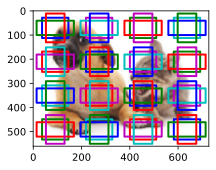

In [3]:
# 探测小目标
# 调用display_anchors函数，输入参数是特征图的宽度（fmap_w=4）、高度（fmap_h=4）以及锚框的尺寸（s=[0.15]）。
# 这行代码将在特征图上生成并显示锚框，特征图的尺寸是4x4，锚框的尺寸是0.15（相对于特征图的尺寸）。
# 对于每个特征图的像素，都会生成一个以该像素为中心，尺寸为0.15的锚框。
display_anchors(fmap_w=4,fmap_h=4,s=[0.15])

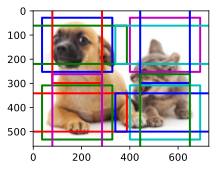

In [4]:
# 将特征图的高度和宽度减小一半，然后使用较大的锚框来检测较大的目标
display_anchors(fmap_w=2,fmap_h=2,s=[0.4])

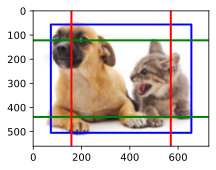

In [5]:
# 将特征图的高度和宽度较小一半，然后将锚框的尺度增加到0.8
display_anchors(fmap_w=1,fmap_h=1,s=[0.8])

# 2. 单发多框检测(SSD)

In [6]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [7]:
# 类别预测层
# 定义一个函数cls_predictor，输入参数分别是输入通道数(num_inputs)、锚框数(num_anchors)以及类别数(num_classes)。
def cls_predictor(num_inputs, num_anchors, num_classes): # 输入通道数、多少个锚框、多少个类
    # 每个锚框的输出通道数都为(num_classes + 1),加1为加的背景类
    # 每一个锚框都要预测他的类别
    # 返回一个卷积层，输入通道数是num_inputs，输出通道数是num_anchors * (num_classes + 1)，
    # 卷积核大小是3，填充大小是1。这里输出通道数乘以(num_classes + 1)的原因是，每个锚框需要预测num_classes + 1个类别的概率，
    # 其中+1是因为增加了背景类（即没有检测到物体的情况）。
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                    kernel_size=3, padding=1)

In [8]:
# 边界框预测层
# 定义一个函数bbox_predictor，输入参数分别是输入通道数(num_inputs)和锚框数(num_anchors)。
def bbox_predictor(num_inputs, num_anchors):
    # 返回一个卷积层，输入通道数是num_inputs，输出通道数是num_anchors * 4，
    # 卷积核大小是3，填充大小是1。这里输出通道数乘以4的原因是，每个锚框需要预测4个值（边界框的中心坐标和宽高）来确定边界框的位置。
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)    

In [9]:
# 连接多尺度的预测
# 定义一个函数forward，输入参数是输入数据x和一个网络层block。
def forward(x, block):
    # 返回通过网络层block处理输入数据x后的结果。
    return block(x)

# 使用全0的输入数据和一个类别预测层，进行前向传播。这里输入数据的形状是(2,8,20,20)，表示有2张图片，每张图片有8个通道，尺寸是20x20。
# 类别预测层的参数是8,5,10，表示输入通道数是8，锚框数是5，类别数是10。
Y1 = forward(torch.zeros((2,8,20,20)),cls_predictor(8,5,10))
# 使用另一个全0的输入数据和一个类别预测层，进行前向传播。这里输入数据的形状是(2,16,10,10)，表示有2张图片，每张图片有16个通道，尺寸是10x10。
# 类别预测层的参数是16,3,10，表示输入通道数是16，锚框数是3，类别数是10。
Y2 = forward(torch.zeros((2,16,10,10)),cls_predictor(16,3,10))
# 打印Y1的形状，这里是(2, 55, 20, 20)，表示有2张图片，每张图片有55个通道，尺寸是20x20。这里的55是因为每个锚框需要预测10+1个类别的概率，共有5个锚框，所以通道数是5*(10+1)=55。
print(Y1.shape) # 5 * (10 + 1) = 55, 55为每一个像素输出的所有锚框数对应的类别
print(Y2.shape) # 2为小批量里面有多少图片

torch.Size([2, 55, 20, 20])
torch.Size([2, 33, 10, 10])


In [10]:
# 定义一个函数flatten_pred，输入参数是预测结果pred。
def flatten_pred(pred):
    # pred.permute(0,2,3,1)通道数放在最后
    # start_dim=1把pred.permute(0,2,3,1)后面三个向量拉成一个向量，这样就变成一个2D矩阵
    # 2D矩阵的高为批量大小，宽为每个图片的所有
    # 如果pred.permute(0,2,3,1)不改的话，对于同一像素的类别预测flatten后会相隔较远
    # 返回拉平后的预测结果。首先使用permute方法调整通道数的位置，然后使用flatten方法将除第一维（批量大小）之外的所有维度拉平。
    return torch.flatten(pred.permute(0,2,3,1),start_dim=1) 

# 定义一个函数concat_preds，输入参数是多个预测结果的列表preds。
def concat_preds(preds):
    #[print(flatten_pred(p).shape) for p in preds]
    # 返回连接后的预测结果。首先使用列表推导式和flatten_pred函数拉平每个预测结果，然后使用torch.cat方法在dim=1的维度上连接所有的预测结果。
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

# 打印连接后的预测结果的形状。这里输入的是两个预测结果Y1和Y2，输出的形状是(2, 35300)，表示有2张图片，每张图片有25300个预测结果。
print(concat_preds([Y1, Y2]).shape)

torch.Size([2, 25300])


In [11]:
# 高和宽减半块
# 定义一个函数down_sample_blk，输入参数是输入通道数(in_channels)和输出通道数(out_channels)。
def down_sample_blk(in_channels, out_channels):
    # 创建一个空列表blk，用于存储网络层。
    blk = []
    # 循环2次，每次添加2个卷积层、1个批量归一化层和1个ReLU激活函数。
    for _ in range(2):
        # 添加一个卷积层，输入通道数是in_channels，输出通道数是out_channels，卷积核大小是3，填充大小是1。
        blk.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))     
        # 添加一个批量归一化层，输入通道数是out_channels。
        blk.append(nn.BatchNorm2d(out_channels))
        # 添加一个ReLU激活函数。
        blk.append(nn.ReLU())
        # 更新输入通道数为当前的输出通道数。
        in_channels = out_channels
    # 添加一个最大池化层，池化核大小是2，这可以将输入数据的高度和宽度减半。
    blk.append(nn.MaxPool2d(2))
    # 返回一个顺序容器，其中包含了所有的网络层。
    return nn.Sequential(*blk)

# 打印通过下采样模块处理后的输出数据的形状。这里输入的是全0的数据，形状是(2,3,20,20)，表示有2张图片，每张图片有3个通道，尺寸是20x20。
# 下采样模块的参数是3和10，表示输入通道数是3，输出通道数是10。输出的形状是(2,10,10,10)，表示有2张图片，每张图片有10个通道，尺寸是10x10。
print(forward(torch.zeros((2,3,20,20)),down_sample_blk(3,10)).shape)

torch.Size([2, 10, 10, 10])


In [12]:
# 基本网络块
# 定义一个函数base_net，没有输入参数。
def base_net(): # 从原始图片抽特征，到第一次featuremao产生锚框，中间的那一截叫base_net  
    # 创建一个空列表blk，用于存储网络层。
    blk = []
    # 定义一个列表num_filters，表示每个下采样模块的输入通道数和输出通道数。
    num_filters = [3,16,32,64] # 通道数由3到16，再到32，再到64
    # 循环遍历num_filters列表，每次添加一个下采样模块。
    for i in range(len(num_filters) - 1):
        # 添加一个下采样模块，输入通道数是num_filters[i]，输出通道数是num_filters[i+1]。
        blk.append(down_sample_blk(num_filters[i],num_filters[i+1]))
    # 返回一个顺序容器，其中包含了所有的网络层。
    return nn.Sequential(*blk)

# 打印通过基础网络模块处理后的输出数据的形状。这里输入的是全0的数据，形状是(2,3,256,256)，表示有2张图片，每张图片有3个通道，尺寸是256x256。
# 输出的形状是(2,64,32,32)，表示有2张图片，每张图片有64个通道，尺寸是32x32。
print(forward(torch.zeros((2,3,256,256)),base_net()).shape)

torch.Size([2, 64, 32, 32])


In [13]:
# 完整的单发多框检测模型由五个模块组成
# 定义一个函数get_blk，输入参数是一个整数i。
def get_blk(i):
    # 如果i等于0，则返回基础网络模块。
    if i == 0:
        # 使得通道数变为64的featuremap
        blk = base_net() # 使得通道数变为64的featuremap
    # 如果i等于1，则返回一个下采样模块，输入通道数是64，输出通道数是128。
    elif i == 1:
        blk = down_sample_blk(64,128) # 通道数变为128
    # 如果i等于4，则返回一个自适应最大池化层，输出尺寸是1x1。
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1)) # 最后一层，把图片压缩到1×1
    # 如果i等于其他值，则返回一个下采样模块，输入通道数是128，输出通道数也是128。
    else:
        blk = down_sample_blk(128, 128)
    # 返回对应的网络模块。
    return blk

In [14]:
# 为每个块定义前向计算
# 定义一个函数blk_forward，输入参数是输入数据X、网络模块blk、锚框大小size、纵横比ratio、类别预测器cls_predictor和边界框预测器bbox_predictor。
def blk_forward(X,blk,size,ratio,cls_predictor,bbox_predictor):
    # 通过网络模块blk处理输入数据X，得到输出数据Y。
    Y = blk(X)
    # 在输出数据Y上生成锚框，锚框的大小是size，纵横比是ratio。
    anchors = d2l.multibox_prior(Y,sizes=size,ratios=ratio)
    # 使用类别预测器cls_predictor预测每个锚框的类别。
    cls_preds = cls_predictor(Y)
    # 使用边界框预测器bbox_predictor预测每个锚框的边界框。
    bbox_preds = bbox_predictor(Y)
    # 返回 卷积层输出、卷积层输出上生成的锚框、每一个锚框的类别的预测，每一个锚框到真实边缘框的预测   
    # 返回输出数据Y、生成的锚框、类别预测结果和边界框预测结果。
    return (Y,anchors,cls_preds,bbox_preds)

In [15]:
# 超参数
# 小的size看小的特征，大的size看整个图片特征
# sizes 是一个二维列表，表示各个尺度下的锚框大小。数值越小，看的特征越小，数值越大，看的是整个图片的特征。
sizes = [[0.2,0.272],[0.37,9.447],[0.54,0.619],[0.71,0.79],[0.88,0.961]]
# ratios 是一个二维列表，表示各个尺度下的锚框纵横比。这里每个尺度下的锚框纵横比都是 [1,2,0.5]。
ratios = [[1,2,0.5]] * 5
# num_anchors 是一个整数，表示每个尺度下的锚框数量。这里的计算方法是：每个尺度下的大小数量 + 每个尺度下的纵横比数量 - 1。   
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [16]:
# 定义完整的模型
# TinySSD 是 PyTorch 的一个自定义模型类，继承自 nn.Module 类。
class TinySSD(nn.Module):
    # 构造函数，输入参数是分类的数量 num_classes 和其他命名参数。
    def __init__(self, num_classes, **kwargs):
        # 调用父类 nn.Module 的构造函数。
        super(TinySSD,self).__init__(**kwargs)
        # 保存分类的数量。
        self.num_classes = num_classes
        # 定义一个列表，表示每个模块的输入通道数。
        idx_to_in_channels = [64,128,128,128,128]
        # 对于每个模块：
        for i in range(5):
            # setattr是给对象的属性赋值
            # 创建模块，并保存到 self 的属性中。
            setattr(self,f'blk_{i}',get_blk(i))
            # 创建类别预测器，并保存到 self 的属性中。
            setattr(self,f'cls_{i}',cls_predictor(idx_to_in_channels[i],num_anchors,num_classes))   
            # 创建边界框预测器，并保存到 self 的属性中。
            setattr(self,f'bbox_{i}',bbox_predictor(idx_to_in_channels[i],num_anchors))      
    
    # 定义前向传播函数，输入参数是输入数据 X。
    def forward(self,X):
        # 初始化锚框、类别预测和边界框预测的列表。
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        # 对于每个模块：
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
            # 进行前向计算，并获取输出数据、锚框、类别预测和边界框预测。
        # 将所有模块的锚框沿着第一个维度（索引从 0 开始）拼接起来。
        anchors = torch.cat(anchors, dim=1) # 把所有的anchors并在一起
        # 将所有模块的类别预测结果拼接起来。
        cls_preds = concat_preds(cls_preds)
        # 将类别预测结果重塑为三维张量，第一维度是批量大小，第二维度是 -1 表示自动计算，第三维度是类别数量+1。
        cls_preds = cls_preds.reshape(cls_preds.shape[0],-1,self.num_classes+1)   
        # 将所有模块的边界框预测结果拼接起来。
        bbox_preds = concat_preds(bbox_preds)
        # 返回锚框、类别预测结果和边界框预测结果。
        return anchors, cls_preds, bbox_preds

In [17]:
# 创建一个模型实例，然后使用它执行前向计算
# 创建一个 TinySSD 类的实例，类别数量为 1。
net = TinySSD(num_classes=1)
# 创建一个全零张量，形状为（32，3，256，256），代表有 32 张 3 通道的 256x256 图像。
X = torch.zeros((32,3,256,256))
# 使用模型进行前向计算，输入是创建的全零张量，输出是锚框、类别预测和边界框预测。
anchors, cls_preds, bbox_preds = net(X)
# 打印锚框的形状，每一张图片都有5444个锚框。
print('output anchors:',anchors.shape) 
# 打印类别预测的形状，32为批量大小，2为类别1加上背景为2。
print('output class preds:',cls_preds.shape) 
# 打印边界框预测的形状，每张图片有5444个锚框，每个锚框有4个坐标，所以是5444*4=21776。
print('output bbox preds:',bbox_preds.shape) 

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [18]:
# 读取香蕉检测数据集
# 设置批量大小为32。
batch_size = 32
# 使用 d2l 的 load_data_bananas 函数加载香蕉检测数据集，只使用训练数据集（train_iter）。
# "_" 是一个常用的占位符，表示我们不关心的变量（在这里，我们不关心测试数据集）。
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [19]:
# 初始化其参数并定义优化算法
# 选择一个可用的设备进行计算（优先选择 GPU），并创建一个 TinySSD 类的实例，类别数量为1。
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
# 使用随机梯度下降（SGD）优化器，学习率设置为 0.2，权重衰减为 5e-4。optimizer 的参数是模型的所有参数。
trainer = torch.optim.SGD(net.parameters(),lr=0.2,weight_decay=5e-4)

In [20]:
# 定义损失函数和评价函数
# 交叉熵损失用于类别预测。reduction 参数设置为 'none' 表示保留每个元素的损失。
cls_loss = nn.CrossEntropyLoss(reduction='none')
# L1 损失用于边界框预测。reduction 参数设置为 'none' 表示保留每个元素的损失。
bbox_loss = nn.L1Loss(reduction='none')

# 定义损失计算函数
# cls_preds 和 cls_labels 是类别预测和标签。
# bbox_preds 和 bbox_labels 是边界框预测和标签。
# bbox_masks 是用于过滤无关的负类样本的掩码。
# 函数返回总损失，即类别损失和边界框损失的和。
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    # 计算类别损失，然后调整形状，以便每个样本有一个损失值。
    cls = cls_loss(cls_preds.reshape(-1,num_classes),cls_labels.reshape(-1)).reshape(batch_size,-1).mean(dim=1)      
    # 计算边界框损失，只考虑非背景的预测。
    # mask使得锚框为背景框时为0，就不预测偏移，否则为1，才预测锚框的偏移。
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)   
    # 返回总损失。
    return cls + bbox

# 定义评价函数
# 计算类别预测的准确性。函数返回正确预测的数量。
def cls_eval(cls_preds,cls_labels):
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype)==cls_labels).sum()) 

# 计算边界框预测的准确性。函数返回所有边界框预测和标签之间的绝对差的和。
def bbox_eval(bbox_preds,bbox_labels,bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())  

class err 3.25e-03, bbox mae 3.04e-03
3202.7 examples/sec oncuda:0


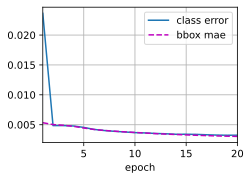

In [21]:
# 训练模型
# 设置训练周期数和计时器
num_epochs, timer = 20, d2l.Timer()
# 创建一个动画对象，用于动态显示训练过程中的类别错误和边界框的平均绝对误差
animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],
                       legend=['class error','bbox mae'])
# 将网络移动到相应的设备（如GPU）
net = net.to(device)
# 开始训练周期
for epoch in range(num_epochs):
    # 创建一个累加器用于存储训练过程中的指标
    metric = d2l.Accumulator(4)
    # 设置网络为训练模式
    net.train()
    # 遍历训练数据
    for features, target in train_iter:
        # 计时开始
        timer.start()
        # 清零梯度
        trainer.zero_grad()
        # 将特征和目标移动到相应的设备
        X, Y = features.to(device), target.to(device)
        # 前向传播，得到锚框、类别预测和边界框预测
        anchors, cls_preds, bbox_preds = net(X)
        # 获取边界框标签、掩码和类别标签
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)   
        # 计算损失
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)  
        # 反向传播，计算梯度
        l.mean().backward()
        # 更新参数
        trainer.step()
        # 更新指标
        metric.add(cls_eval(cls_preds,cls_labels),cls_labels.numel(),
                  bbox_eval(bbox_preds,bbox_labels,bbox_masks),
                  bbox_labels.numel())
    # 计算类别错误率和边界框平均绝对误差
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    # 更新动画
    animator.add(epoch + 1, (cls_err, bbox_mae))

# 打印最后的类别错误率和边界框平均绝对误差
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
# 打印训练速度和设备信息
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on'
     f'{str(device)}')

In [22]:
# 预测目标
# 读取待预测的图片，并将其转换为浮点型张量
X = torchvision.io.read_image('01_Data/04_banana.jpg').unsqueeze(0).float()
# 从四维张量中移除单维条目，然后调整各维度的顺序，最后转换为长整型张量
img = X.squeeze(0).permute(1,2,0).long()

# 定义预测函数
def predict(X):
    # 将网络设置为评估模式
    net.eval()
    # 前向传播，得到锚框、类别预测和边界框预测
    anchors, cls_preds, bbox_preds = net(X.to(device))
    # 对类别预测进行softmax操作，得到类别概率，然后调整各维度的顺序
    cls_probs = F.softmax(cls_preds,dim=2).permute(0,2,1) # softmax使得变成概率
    # 调用多框检测函数，得到预测结果
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors) # 里面调用了NMS   
    # 获取置信度不为-1的预测结果的索引
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    # 返回置信度最大的预测结果
    return output[0, idx] # 只要置信度最大的框

# 对图片进行预测
output = predict(X)

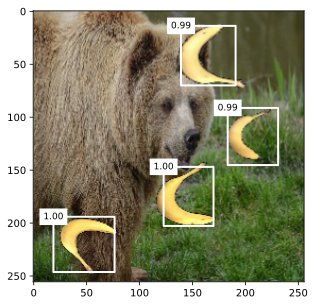

In [23]:
# 筛选所有置信度不低于0.9的边界框，做为最终输出
# 定义显示边界框的函数
def display(img, output, threshold):
    # 设置图像大小
    d2l.set_figsize((5,5))
    # 展示图像
    fig = d2l.plt.imshow(img)
    # 遍历预测结果
    for row in output:
        # 获取置信度
        score = float(row[1])
        # 如果置信度低于阈值，则忽略该预测结果
        if score < threshold:
            continue
        # 获取图像的高度和宽度
        h, w = img.shape[0:2]
        # 获取预测的边界框，并将其转换为实际像素坐标
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        # 显示边界框
        d2l.show_bboxes(fig.axes,bbox,'%.2f' % score,'w')

# 显示置信度不低于0.9的边界框
display(img,output.cpu(),threshold=0.9)

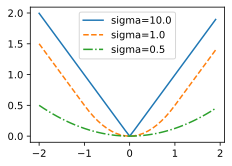

In [24]:
# 定义平滑L1损失函数
def smooth_11(data, scalar):
    out = []
    # 遍历输入数据
    for i in data:
        # 对于绝对值小于1/scalar^2的数据，采用平方损失
        if abs(i) < 1 / (scalar**2):
            out.append(((scalar * i)**2) / 2)
        # 对于绝对值大于1/scalar^2的数据，采用绝对值损失
        else:
            out.append(abs(i) - 0.5 / (scalar**2))
    # 返回平滑L1损失
    return torch.tensor(out)

# 定义不同的sigma值
sigmas = [10, 1, 0.5]
# 定义不同的线型
lines = ['-','--','-.']
# 定义x值范围
x = torch.arange(-2,2,0.1)
# 设置图像大小
d2l.set_figsize()

# 遍历不同的sigma值
for l, s in zip(lines,sigmas):
    # 计算平滑L1损失
    y = smooth_11(x,scalar=s)
    # 绘制损失函数曲线
    d2l.plt.plot(x,y,l,label='sigma=%.1f' % s)

# 显示图例
d2l.plt.legend()

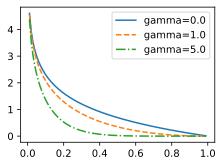

In [25]:
# 定义焦点损失函数
def focal_loss(gamma, x):
    # 根据公式计算焦点损失
    return -(1 - x)**gamma * torch.log(x)

# 定义x值范围
x = torch.arange(0.01, 1, 0.01)
# 遍历不同的gamma值
for l, gamma in zip(lines, [0, 1, 5]):
    # 计算焦点损失
    y = d2l.plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)   

# 显示图例
d2l.plt.legend()